
# Vegetation Moisture Prediction Using Time Series Analysis

**Objective**: Predict vegetation moisture using time series data and machine learning techniques.
- Focus on environmental and agricultural applications (e.g., wildfire prevention, drought monitoring, crop management).

**Core Model: Use Long Short-Term Memory (LSTM) networks**
- LSTM handles sequential data and long-term dependencies in time series.

**Uncertainty Estimation: Integrate Monte Carlo Dropout**
- Provides uncertainty bounds on predictions, improving decision-making by accounting for model uncertainty.

**Interpretability: Apply SHAP values to explain model predictions **
- SHAP values offer insights into how input features contribute to the model’s output, improving trust and transparency.

**Design Goals**
- Deliver **robust**, **interpretable**, and **scalable** vegetation moisture predictions.
- Support **critical decision-making** in agriculture and environmental monitoring.

## Data Sources and Preprocessing
The dataset comprises remote sensing and meteorological data collected over two years. Sentinel-1 Synthetic Aperture Radar (SAR) data provides C-band backscatter coefficients, which are sensitive to surface moisture and vegetation structure. Optical imagery from Sentinel-2 is used to calculate essential vegetation indices, including the Normalized Difference Vegetation Index (NDVI), Normalized Difference Water Index (NDWI), Green Chlorophyll Index (GCI), and Moisture Stress Index (MSI). Additionally, meteorological data from ERA5 reanalysis captures critical variables such as temperature, precipitation, and relative humidity. Together, these datasets form the foundation for the time series analysis.

To prepare the data, vegetation indices are aggregated over spatial regions defined by polygons corresponding to specific vegetation types. Temporal data is aligned and processed to create daily time series, enabling the analysis of vegetation dynamics and seasonal trends. This preprocessing ensures consistency across all data sources while maintaining the temporal resolution necessary for accurate modeling.

## Modeling Approach
The predictive framework is built around the LSTM architecture, a recurrent neural network known for its ability to model long-term dependencies in sequential data. LSTMs are particularly well-suited for this project due to their capacity to capture complex temporal patterns in vegetation indices and environmental variables. Monte Carlo Dropout is integrated into the model to provide uncertainty quantification, enabling more reliable predictions by estimating the range of possible outcomes.

To enhance interpretability, SHAP values are employed to assess the contribution of each input feature to the model’s predictions. This approach allows for a deeper understanding of the relationship between vegetation indices, SAR backscatter, meteorological factors, and the predicted moisture levels. Such insights are valuable for identifying key drivers of vegetation moisture and improving trust in the model's outputs.

## Framework Design
The project’s methodology consists of three main stages. First, vegetation indices and spatial mappings are calculated by aggregating data over regions defined by vegetation types. This step helps capture the average vegetation health and moisture characteristics for specific areas. Next, the aggregated data is compiled into continuous time series, facilitating the analysis of temporal trends and enabling robust forecasting. Finally, the LSTM model processes the time series data to generate moisture predictions, complemented by uncertainty estimation through Monte Carlo Dropout.

A comprehensive diagram of the framework illustrates the integration of remote sensing data, meteorological information, and advanced modeling techniques to deliver accurate and explainable predictions. ![Framework Diagram](Diagram/framework_diagram.png)

In [2]:
import ee
from IPython.display import Image

# Authenticate to the Earth Engine servers
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AeanS0YzCn2mrbWIcTdk1gy2pO3JdQWJELdXoniZOJOzQxmoJT_w7oDKVgE

Successfully saved authorization token.


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


Possible issue encountered when converting Shape #1 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.


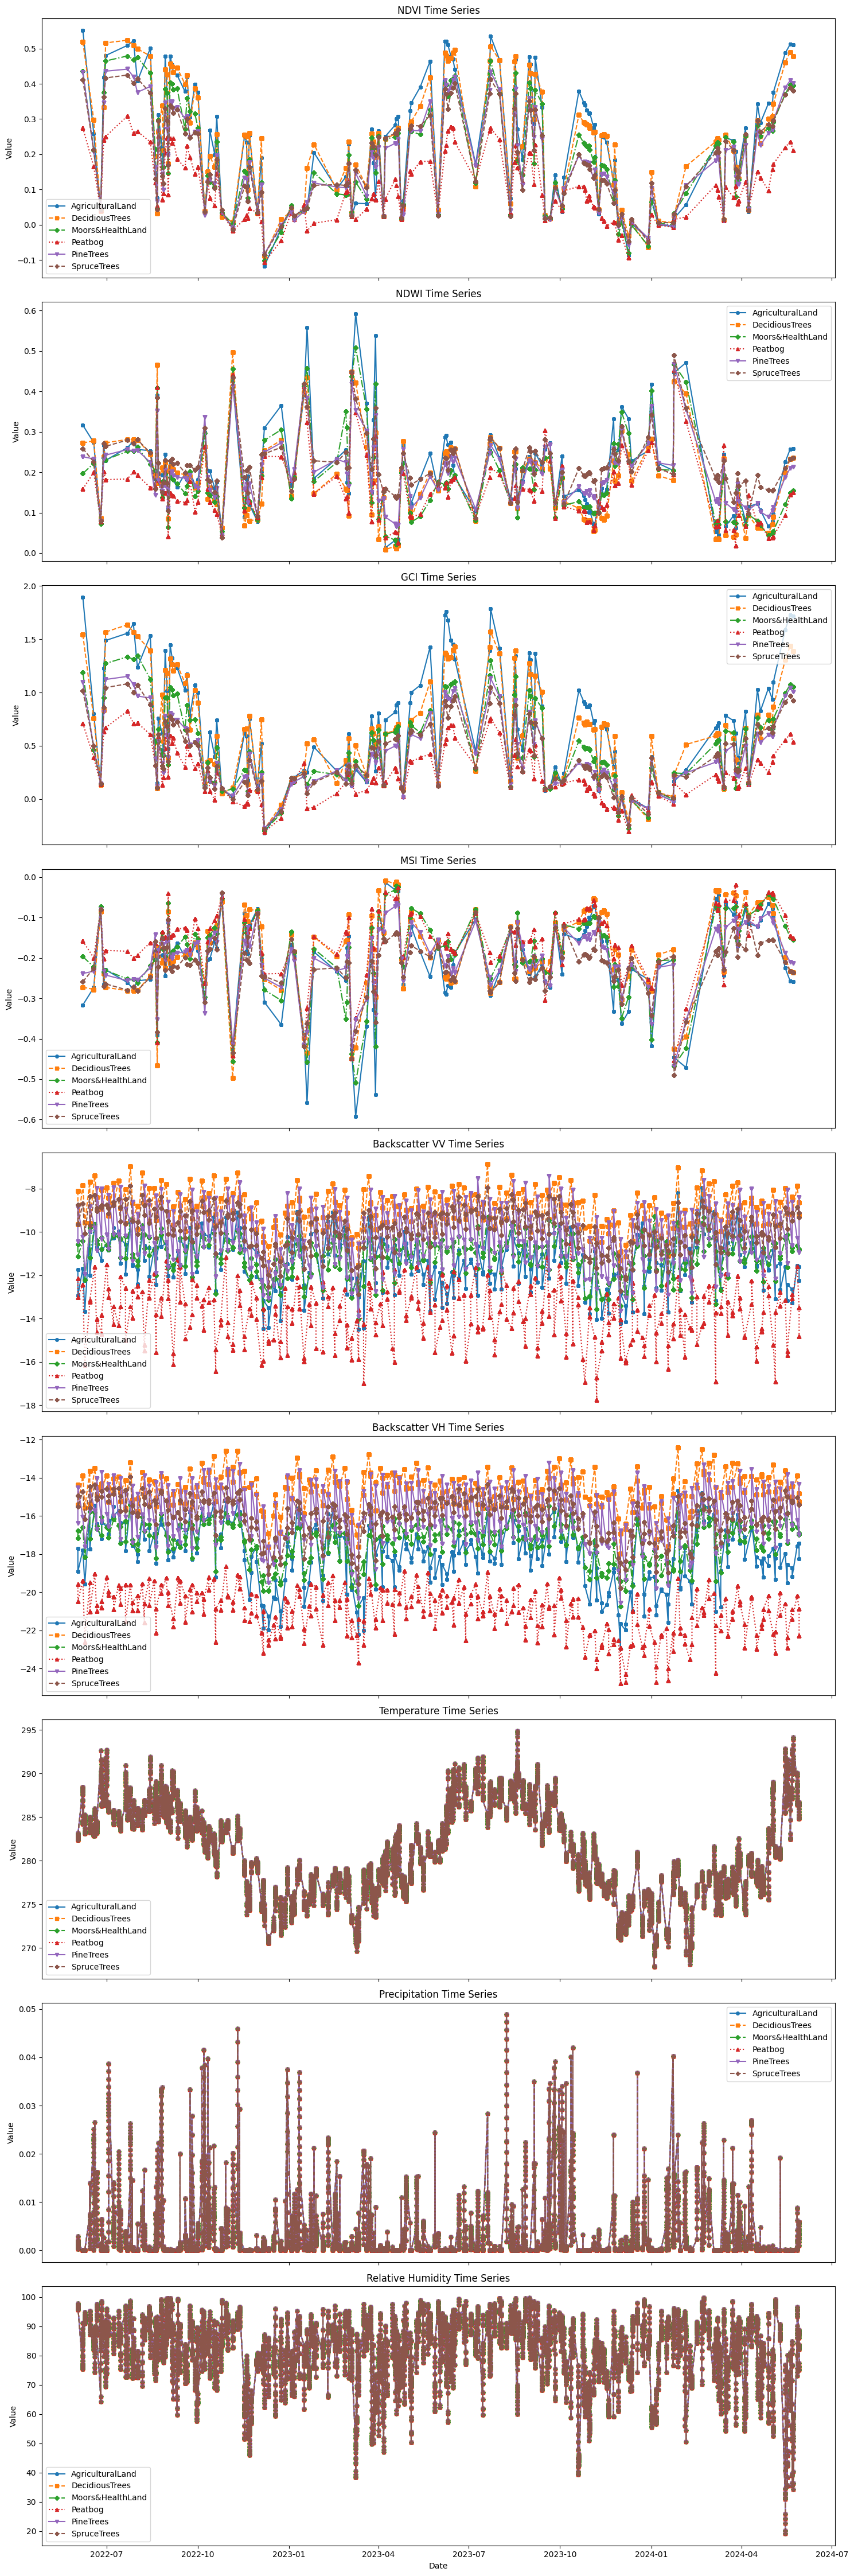

In [3]:
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# Initialize the Earth Engine module.
ee.Initialize()

# Function to calculate relative humidity
def calculate_relative_humidity(temp, dewpoint_temp):
    return 100 - 5 * (temp - dewpoint_temp)

# Define the function to calculate NDVI, NDWI, GCI, and MSI
def calculate_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B8', 'B11']).rename('NDWI')
    gci = image.expression('(NIR / GREEN) - 1', {
        'NIR': image.select('B8'),
        'GREEN': image.select('B3')
    }).rename('GCI')
    msi = image.normalizedDifference(['B11', 'B8']).rename('MSI')  # MSI calculation
    date = image.date().format('YYYY-MM-dd')
    return image.addBands([ndvi, ndwi, gci, msi]).set('date', date)

# Define the function to calculate backscatter for VV and VH
def calculate_backscatter(image):
    backscatter_vv = image.select('VV').rename('Backscatter_VV')
    backscatter_vh = image.select('VH').rename('Backscatter_VH')
    date = image.date().format('YYYY-MM-dd')
    return image.addBands([backscatter_vv, backscatter_vh]).set('date', date)

# Path to the folder containing the shapefiles.
shp_folder = 'Shapefiles/'

# List of shapefiles in the folder.
shapefiles = ['AgriculturalLand.shp', 'DecidiousTrees.shp', 'Moors&HealthLand.shp', 'Peatbog.shp', 'PineTrees.shp', 'SpruceTrees.shp']

# Function to check if the shapefile exists
def shapefile_exists(path):
    return os.path.exists(path)

# DataFrame to store indices time series.
indices_df = pd.DataFrame()

# Define the date range.
start_date = '2022-06-01'
end_date = '2024-05-31'

# Process each shapefile.
for shp in shapefiles:
    shp_path = os.path.join(shp_folder, shp)
    
    if not shapefile_exists(shp_path):
        print(f"Shapefile {shp_path} does not exist.")
        continue

    # Load the shapefile.
    shapefile_fc = geemap.shp_to_ee(shp_path)
    
    if shapefile_fc is None:
        print(f"Could not load shapefile {shp_path}.")
        continue

    geometry = shapefile_fc.geometry()

    # Load Sentinel-2 image collection, filter by cloud cover, and sort by cloud cover percentage.
    s2_collection = (ee.ImageCollection('COPERNICUS/S2')
                     .filterDate(start_date, end_date)
                     .filterBounds(geometry)
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
                     .select(['B4', 'B8', 'B3','B11' ])
                     .map(calculate_indices))

    # Load Sentinel-1 image collection, filter by date and bounds, and get VV and VH backscatter.
    s1_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filterDate(start_date, end_date)
                     .filterBounds(geometry)
                     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                     .select(['VV', 'VH'])
                     .map(calculate_backscatter))

    # Use an iterate function to get indices and backscatter values over time.
    def accumulate_indices(image, list):
        date = image.get('date')
        ndvi_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('NDVI')
        ndwi_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('NDWI')
        gci_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('GCI')
        msi_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('MSI')
        feature = ee.Feature(None, {'date': date, 'NDVI': ndvi_value, 'NDWI': ndwi_value, 'GCI': gci_value, 'MSI': msi_value, 'shapefile': shp})
        return ee.List(list).add(feature)

    def accumulate_backscatter(image, list):
        date = image.get('date')
        backscatter_vv = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('Backscatter_VV')
        backscatter_vh = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('Backscatter_VH')
        feature = ee.Feature(None, {'date': date, 'Backscatter_VV': backscatter_vv, 'Backscatter_VH': backscatter_vh, 'shapefile': shp})
        return ee.List(list).add(feature)

    initial_list = ee.List([])
    indices_time_series = ee.List(s2_collection.iterate(accumulate_indices, initial_list))
    backscatter_time_series = ee.List(s1_collection.iterate(accumulate_backscatter, initial_list))

    # Convert the lists to FeatureCollections
    indices_fc = ee.FeatureCollection(indices_time_series)
    backscatter_fc = ee.FeatureCollection(backscatter_time_series)

    # Get the indices values and dates
    indices_info = indices_fc.getInfo()
    backscatter_info = backscatter_fc.getInfo()

    for feature in indices_info['features']:
        date = feature['properties']['date']
        ndvi_value = feature['properties']['NDVI']
        ndwi_value = feature['properties']['NDWI']
        gci_value = feature['properties']['GCI']
        msi_value = feature['properties']['MSI']
        indices_df = pd.concat([indices_df, pd.DataFrame([{
            'Date': date,
            'NDVI': ndvi_value,
            'NDWI': ndwi_value,
            'GCI': gci_value,
            'MSI': msi_value,
            'Shapefile': shp
        }])], ignore_index=True)

    for feature in backscatter_info['features']:
        date = feature['properties']['date']
        backscatter_vv = feature['properties']['Backscatter_VV']
        backscatter_vh = feature['properties']['Backscatter_VH']
        indices_df = pd.concat([indices_df, pd.DataFrame([{
            'Date': date,
            'Backscatter_VV': backscatter_vv,
            'Backscatter_VH': backscatter_vh,
            'Shapefile': shp
        }])], ignore_index=True)

# Convert 'Date' column to datetime
indices_df['Date'] = pd.to_datetime(indices_df['Date'])

# Display the DataFrame to ensure data is collected
#print("Contents of indices_df:")
#print(indices_df.head())

# Save the indices DataFrame to a CSV file
indices_df.to_csv('indices_timeseries_with_msi_and_backscatter.csv', index=False)

# Load ERA5 data
region = ee.Geometry.Point([5.032779673636611, 61.362695116812176])
era5_collection = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterBounds(region)

# Use an iterate function to aggregate temperature and precipitation data in smaller chunks.
data_list = []

# Define the start and end dates for the iteration
current_start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

while current_start_date < end_date_dt:
    current_end_date = current_start_date + timedelta(days=30)
    if current_end_date > end_date_dt:
        current_end_date = end_date_dt
    
    era5_filtered = era5_collection.filterDate(current_start_date.strftime('%Y-%m-%d'), current_end_date.strftime('%Y-%m-%d'))
    
    def aggregate_data(image, list):
        date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
        temp = image.select('temperature_2m').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000
        ).get('temperature_2m')
        dewpoint_temp = image.select('dewpoint_temperature_2m').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000
        ).get('dewpoint_temperature_2m')
        precip = image.select('total_precipitation').reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=10000
        ).get('total_precipitation')
        u_wind = image.select('u_component_of_wind_10m').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000
        ).get('u_component_of_wind_10m')
        v_wind = image.select('v_component_of_wind_10m').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000
        ).get('v_component_of_wind_10m')
        
        wind_speed = (ee.Number(u_wind).pow(2).add(ee.Number(v_wind).pow(2))).sqrt()
        
        feature = ee.Feature(None, {
            'date': date,
            'Temperature': temp,
            'DewpointTemperature': dewpoint_temp,
            'Precipitation': precip,
            'WindSpeed': wind_speed
        })
        return ee.List(list).add(feature)
    
    initial_list = ee.List([])
    data_time_series = ee.List(era5_filtered.iterate(aggregate_data, initial_list))
    
    # Convert the list to a FeatureCollection
    data_fc = ee.FeatureCollection(data_time_series)
    
    # Get the data values and dates
    data_info = data_fc.getInfo()
    
    # Append data to list
    for feature in data_info['features']:
        properties = feature['properties']
        data_list.append({
            'Date': properties['date'],
            'Temperature': properties['Temperature'],
            'DewpointTemperature': properties['DewpointTemperature'],
            'Precipitation': properties['Precipitation'],
            'WindSpeed': properties['WindSpeed']
        })
    
    # Move to the next time chunk
    current_start_date = current_end_date

# Create a DataFrame from the aggregated data
data_df = pd.DataFrame(data_list)

# Convert 'Date' column to datetime
data_df['Date'] = pd.to_datetime(data_df['Date'])

# Display the DataFrame to ensure data is collected
#print("Contents of data_df:")
#print(data_df.head())

# Save the ERA5 data to a CSV file
data_df.to_csv('era5_data_with_msi_backscatter.csv', index=False)

# Calculate relative humidity and add to the DataFrame
data_df['RelativeHumidity'] = calculate_relative_humidity(data_df['Temperature'], data_df['DewpointTemperature'])

# Merge the indices DataFrame with temperature, precipitation, wind speed, and relative humidity data.
combined_df = pd.merge(indices_df, data_df, on='Date', how='left')

# Display the combined DataFrame to ensure data is merged correctly
#print("Contents of combined_df:")
#print(combined_df.head())

# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined_timeseries_with_msi_and_backscatter.csv', index=False)

# Directory to save plots
plot_directory = 'Indices_Plots_With_MSI_Backscatter'
os.makedirs(plot_directory, exist_ok=True)

# Define different line styles and markers
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', '^', 'v', 'P']

# Plot NDVI, NDWI, GCI, MSI, Backscatter VV, Backscatter VH, Temperature, Precipitation, and Relative Humidity time series for all shapefiles in a single figure and save as PNG
fig, axs = plt.subplots(9, 1, figsize=(15, 45), sharex=True)

shapefile_names = [os.path.splitext(shp)[0] for shp in shapefiles]

for i, shp in enumerate(shapefiles):
    shp_indices = combined_df[combined_df['Shapefile'] == shp]
    
    # Use simple names for legend
    simple_name = shapefile_names[i]
    
    # Plot NDVI, NDWI, GCI, MSI, Backscatter VV, and VH
    axs[0].plot(shp_indices['Date'], shp_indices['NDVI'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[1].plot(shp_indices['Date'], shp_indices['NDWI'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[2].plot(shp_indices['Date'], shp_indices['GCI'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[3].plot(shp_indices['Date'], shp_indices['MSI'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[4].plot(shp_indices['Date'], shp_indices['Backscatter_VV'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[5].plot(shp_indices['Date'], shp_indices['Backscatter_VH'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    
    # Sorting for Temperature, Precipitation, and Relative Humidity
    sorted_shp_indices = shp_indices.sort_values(by='Date')
    axs[6].plot(sorted_shp_indices['Date'], sorted_shp_indices['Temperature'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[7].plot(sorted_shp_indices['Date'], sorted_shp_indices['Precipitation'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[8].plot(sorted_shp_indices['Date'], sorted_shp_indices['RelativeHumidity'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)

axs[0].set_title('NDVI Time Series')
axs[1].set_title('NDWI Time Series')
axs[2].set_title('GCI Time Series')
axs[3].set_title('MSI Time Series')
axs[4].set_title('Backscatter VV Time Series')
axs[5].set_title('Backscatter VH Time Series')
axs[6].set_title('Temperature Time Series')
axs[7].set_title('Precipitation Time Series')
axs[8].set_title('Relative Humidity Time Series')

for ax in axs:
    ax.set_ylabel('Value')
    ax.legend()

axs[-1].set_xlabel('Date')

plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'Indices_Time_Series_All_Shapefiles_with_MSI_Backscatter.png'))
plt.show()


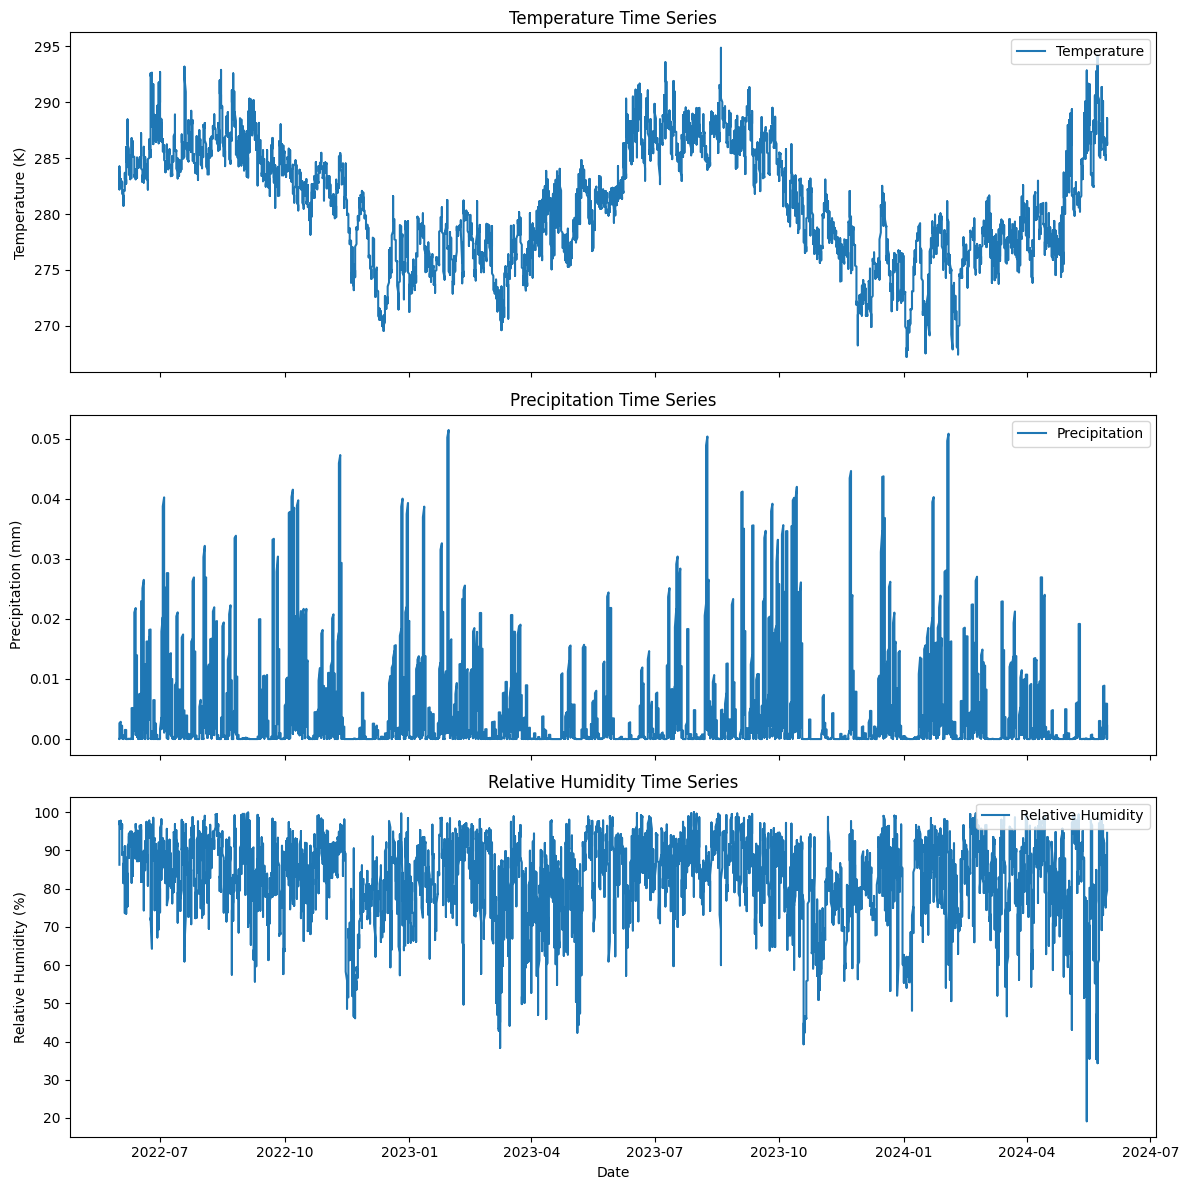

In [4]:
import matplotlib.pyplot as plt

# Choose a single consistent color for all plots
color = 'tab:blue'

# Create a new figure and separate axes for each variable
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot Temperature on the first axis
axs[0].plot(data_df['Date'], data_df['Temperature'], color=color, label='Temperature')
axs[0].set_title('Temperature Time Series')
axs[0].set_ylabel('Temperature (K)')
axs[0].legend(loc='upper right')

# Plot Precipitation on the second axis
axs[1].plot(data_df['Date'], data_df['Precipitation'], color=color, label='Precipitation')
axs[1].set_title('Precipitation Time Series')
axs[1].set_ylabel('Precipitation (mm)')
axs[1].legend(loc='upper right')

# Plot Relative Humidity on the third axis
axs[2].plot(data_df['Date'], data_df['RelativeHumidity'], color=color, label='Relative Humidity')
axs[2].set_title('Relative Humidity Time Series')
axs[2].set_ylabel('Relative Humidity (%)')
axs[2].legend(loc='upper right')

# Set shared x-axis label
axs[2].set_xlabel('Date')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PDF file
plt.savefig('separate_timeseries_plots.pdf')

# Show the plot
plt.show()


In [5]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Ensure 'Date' column is in datetime format
indices_df['Date'] = pd.to_datetime(indices_df['Date'])

# Separate Sentinel-2 (NDVI, NDWI, GCI, MSI) and Sentinel-1 (Backscatter VV, VH) data
s2_df = indices_df[['Date', 'NDVI', 'NDWI', 'GCI', 'MSI', 'Shapefile']].dropna()
s1_df = indices_df[['Date', 'Backscatter_VV', 'Backscatter_VH', 'Shapefile']].dropna()

# Initialize an empty list to store the merged results
merged_list = []

# Loop through each shapefile group
for shapefile in s2_df['Shapefile'].unique():
    # Filter data for the current shapefile
    s2_shapefile_df = s2_df[s2_df['Shapefile'] == shapefile]
    s1_shapefile_df = s1_df[s1_df['Shapefile'] == shapefile]

    # Extract unique, sorted dates for both Sentinel-2 and Sentinel-1 data
    s2_dates = s2_shapefile_df[['Date']].drop_duplicates().sort_values(by='Date').reset_index(drop=True)
    s1_dates = s1_shapefile_df[['Date']].drop_duplicates().sort_values(by='Date').reset_index(drop=True)

    # Convert dates to Unix timestamps (seconds since epoch)
    s2_timestamps = s2_dates['Date'].view(np.int64) // 10**9  # Convert to seconds
    s1_timestamps = s1_dates['Date'].view(np.int64) // 10**9  # Convert to seconds

    # Create KDTree for nearest neighbor search on dates
    tree = cKDTree(s1_timestamps.values.reshape(-1, 1))

    # Find nearest Sentinel-1 dates for each Sentinel-2 date
    _, indices = tree.query(s2_timestamps.values.reshape(-1, 1), k=1)

    # Map nearest Sentinel-1 dates to Sentinel-2 dates
    s2_dates['Nearest_S1_Date'] = s1_dates.iloc[indices.flatten()]['Date'].values

    # Merge Sentinel-2 data with nearest Sentinel-1 data based on the nearest date
    s2_merged_df = pd.merge(s2_shapefile_df, s2_dates[['Date', 'Nearest_S1_Date']], left_on='Date', right_on='Date', how='left')
    shapefile_merged_df = pd.merge(s2_merged_df, s1_shapefile_df, left_on='Nearest_S1_Date', right_on='Date', suffixes=('_S2', '_S1'))

    # Drop unnecessary columns and rename if needed
    shapefile_merged_df = shapefile_merged_df.drop(columns=['Date_S2', 'Date_S1'])

    # Append the merged data for this shapefile to the merged_list
    merged_list.append(shapefile_merged_df)

# Concatenate all shapefile-specific DataFrames into a single DataFrame
final_merged_df = pd.concat(merged_list, ignore_index=True)

# Save the merged DataFrame to a CSV file
final_merged_df.to_csv('nearest_date_merged_timeseries.csv', index=False)

# Display the DataFrame to ensure data is merged correctly
print("Contents of final_merged_df:")
print(final_merged_df.head())


Contents of final_merged_df:
       NDVI      NDWI       GCI       MSI          Shapefile_S2  \
0  0.551571  0.316482  1.894370 -0.316482  AgriculturalLand.shp   
1  0.259208  0.273383  0.801816 -0.273383  AgriculturalLand.shp   
2  0.041419  0.074193  0.139461 -0.074193  AgriculturalLand.shp   
3  0.041419  0.074193  0.139461 -0.074193  AgriculturalLand.shp   
4  0.418440  0.266290  1.227023 -0.266290  AgriculturalLand.shp   

  Nearest_S1_Date  Backscatter_VV  Backscatter_VH          Shapefile_S1  
0      2022-06-07      -11.687209      -17.791403  AgriculturalLand.shp  
1      2022-06-19       -9.619064      -15.459722  AgriculturalLand.shp  
2      2022-06-26      -11.331495      -17.195335  AgriculturalLand.shp  
3      2022-06-26      -10.816755      -16.354668  AgriculturalLand.shp  
4      2022-06-26      -11.331495      -17.195335  AgriculturalLand.shp  


In [6]:
final_merged_df

NDVI      NDWI       GCI       MSI          Shapefile_S2  \
0     0.551571  0.316482  1.894370 -0.316482  AgriculturalLand.shp   
1     0.259208  0.273383  0.801816 -0.273383  AgriculturalLand.shp   
2     0.041419  0.074193  0.139461 -0.074193  AgriculturalLand.shp   
3     0.041419  0.074193  0.139461 -0.074193  AgriculturalLand.shp   
4     0.418440  0.266290  1.227023 -0.266290  AgriculturalLand.shp   
...        ...       ...       ...       ...                   ...   
1393  0.368621  0.210172  0.910856 -0.210172       SpruceTrees.shp   
1394  0.387842  0.232494  0.969278 -0.232494       SpruceTrees.shp   
1395  0.387842  0.232494  0.969278 -0.232494       SpruceTrees.shp   
1396  0.380017  0.235890  0.925875 -0.235890       SpruceTrees.shp   
1397  0.380017  0.235890  0.925875 -0.235890       SpruceTrees.shp   

     Nearest_S1_Date  Backscatter_VV  Backscatter_VH          Shapefile_S1  
0         2022-06-07      -11.687209      -17.791403  AgriculturalLand.shp  
1         2022-06-19       -9.619064      -15.459722  AgriculturalLand.shp  
2         2022-06-26      -11.331495      -17.195335  AgriculturalLand.shp  
3         2022-06-26      -10.816755      -16.354668  AgriculturalLand.shp  
4         2022-06-26      -11.331495      -17.195335  AgriculturalLand.shp  
...              ...             ...             ...                   ...  
1393      2024-05-15       -8.894778      -14.683371       SpruceTrees.shp  
1394      2024-05-22       -9.133885      -15.216801       SpruceTrees.shp  
1395      2024-05-22       -9.487554      -15.303756       SpruceTrees.shp  
1396      2024-05-22       -9.133885      -15.216801       SpruceTrees.shp  
1397      2024-05-22       -9.487554      -15.303756       SpruceTrees.shp  

[1398 rows x 9 columns]

In [7]:
import pandas as pd
import ee
from datetime import timedelta, datetime

# Initialize the Earth Engine module
ee.Initialize()

# Function to aggregate ERA5 data in smaller chunks
def aggregate_era5_data_chunked(start_date, end_date, region, chunk_size_days=30):
    all_data = []
    
    # Convert start and end dates to datetime objects
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Process data in chunks
    current_start_date = start_date_dt
    while current_start_date <= end_date_dt:
        current_end_date = min(current_start_date + timedelta(days=chunk_size_days - 1), end_date_dt)
        
        # Define the date range
        start_str = current_start_date.strftime('%Y-%m-%d')
        end_str = current_end_date.strftime('%Y-%m-%d')
        
        # Filter ERA5 collection by date range
        era5_collection_chunk = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
            .filterBounds(region) \
            .filterDate(start_str, end_str)
        
        # Define a function to calculate daily averages
        def aggregate_data(image, list):
            date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
            u_wind = image.select('u_component_of_wind_10m').reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=10000
            ).get('u_component_of_wind_10m')
            v_wind = image.select('v_component_of_wind_10m').reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=10000
            ).get('v_component_of_wind_10m')
            precip = image.select('total_precipitation').reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=10000
            ).get('total_precipitation')
            feature = ee.Feature(None, {'date': date, 'u_wind': u_wind, 'v_wind': v_wind, 'Precipitation': precip})
            return ee.List(list).add(feature)
        
        # Iterate over the collection
        initial_list = ee.List([])
        data_time_series = ee.List(era5_collection_chunk.iterate(aggregate_data, initial_list))
        
        # Convert the list to a FeatureCollection
        data_fc = ee.FeatureCollection(data_time_series)
        
        # Get the data values and dates
        data_info = data_fc.getInfo()
        
        # Append data to list
        for feature in data_info['features']:
            properties = feature['properties']
            all_data.append({
                'Date': properties['date'],
                'u_wind': properties['u_wind'],
                'v_wind': properties['v_wind'],
                'Precipitation': properties['Precipitation']
            })
        
        # Update current start date for next chunk
        current_start_date = current_end_date + timedelta(days=1)
    
    # Create a DataFrame from the aggregated data
    data_df = pd.DataFrame(all_data)
    
    # Convert 'Date' column to datetime
    data_df['Date'] = pd.to_datetime(data_df['Date'])
    
    return data_df

# Define region of interest
region = ee.Geometry.Point([5.032779673636611, 61.362695116812176])

# Load ERA5 data
start_date = '2022-06-01'
end_date = '2024-05-31'

# Aggregate ERA5 wind data
era5_wind_df = aggregate_era5_data_chunked(start_date, end_date, region)

# Display the aggregated ERA5 wind data
print("ERA5 Wind Data:")
print(era5_wind_df.head())

# Save the ERA5 wind data to a CSV file
era5_wind_df.to_csv('era5_wind_data.csv', index=False)


ERA5 Wind Data:
        Date    u_wind    v_wind  Precipitation
0 2022-06-01 -0.464813 -4.344177   2.317131e-05
1 2022-06-01 -0.882324 -3.341370   0.000000e+00
2 2022-06-01 -0.828369 -2.162853   0.000000e+00
3 2022-06-01 -0.471786 -1.452538   0.000000e+00
4 2022-06-01 -0.265640 -1.447382   8.568168e-07


In [10]:
import pandas as pd

# Ensure 'Date' column is in datetime format
data_df['Date'] = pd.to_datetime(data_df['Date'])

# Aggregate the weather data to daily values
aggregated_weather_df = data_df.groupby(data_df['Date'].dt.date).agg({
    'Temperature': 'mean',            # Average daily temperature
    'DewpointTemperature': 'mean',    # Average daily dewpoint
    'Precipitation': 'sum',           # Total daily precipitation
    'WindSpeed': 'mean',              # Average daily wind speed
    'RelativeHumidity': 'mean'        # Average daily relative humidity
}).reset_index()

# Convert 'Date' back to datetime for merging
aggregated_weather_df['Date'] = pd.to_datetime(aggregated_weather_df['Date'])

# Display the aggregated weather DataFrame to ensure aggregation worked
print("Aggregated Weather Data (one row per day):")
print(aggregated_weather_df.head())



Aggregated Weather Data (one row per day):
        Date  Temperature  DewpointTemperature  Precipitation  WindSpeed  \
0 2022-06-01   283.332890           281.880213       0.010852   5.041773   
1 2022-06-02   282.697495           282.041532       0.032226   4.216259   
2 2022-06-03   282.320800           280.613212       0.013356   6.438830   
3 2022-06-04   281.550916           278.632509       0.004367   4.552091   
4 2022-06-05   283.036395           279.422485       0.032017   4.927244   

   RelativeHumidity  
0         92.736616  
1         96.720184  
2         91.462059  
3         85.407966  
4         81.930450  


In [11]:
aggregated_weather_df

Date  Temperature  DewpointTemperature  Precipitation  WindSpeed  \
0   2022-06-01   283.332890           281.880213       0.010852   5.041773   
1   2022-06-02   282.697495           282.041532       0.032226   4.216259   
2   2022-06-03   282.320800           280.613212       0.013356   6.438830   
3   2022-06-04   281.550916           278.632509       0.004367   4.552091   
4   2022-06-05   283.036395           279.422485       0.032017   4.927244   
..         ...          ...                  ...            ...        ...   
725 2024-05-26   288.785796           285.846197       0.017008   2.318476   
726 2024-05-27   287.873754           285.541748       0.058073   3.155295   
727 2024-05-28   286.236796           283.423080       0.040656   4.767803   
728 2024-05-29   285.799218           282.520267       0.113030   4.697707   
729 2024-05-30   287.444290           284.685297       0.029296   5.071646   

     RelativeHumidity  
0           92.736616  
1           96.720184  
2           91.462059  
3           85.407966  
4           81.930450  
..                ...  
725         85.302006  
726         88.339971  
727         85.931419  
728         83.605245  
729         86.205037  

[730 rows x 6 columns]

In [12]:
final_merged_df.rename(columns={'Nearest_S1_Date': 'Date'}, inplace=True)

In [13]:
aggregated_weather_df

Date  Temperature  DewpointTemperature  Precipitation  WindSpeed  \
0   2022-06-01   283.332890           281.880213       0.010852   5.041773   
1   2022-06-02   282.697495           282.041532       0.032226   4.216259   
2   2022-06-03   282.320800           280.613212       0.013356   6.438830   
3   2022-06-04   281.550916           278.632509       0.004367   4.552091   
4   2022-06-05   283.036395           279.422485       0.032017   4.927244   
..         ...          ...                  ...            ...        ...   
725 2024-05-26   288.785796           285.846197       0.017008   2.318476   
726 2024-05-27   287.873754           285.541748       0.058073   3.155295   
727 2024-05-28   286.236796           283.423080       0.040656   4.767803   
728 2024-05-29   285.799218           282.520267       0.113030   4.697707   
729 2024-05-30   287.444290           284.685297       0.029296   5.071646   

     RelativeHumidity  
0           92.736616  
1           96.720184  
2           91.462059  
3           85.407966  
4           81.930450  
..                ...  
725         85.302006  
726         88.339971  
727         85.931419  
728         83.605245  
729         86.205037  

[730 rows x 6 columns]

In [14]:
final_merged_df

NDVI      NDWI       GCI       MSI          Shapefile_S2       Date  \
0     0.551571  0.316482  1.894370 -0.316482  AgriculturalLand.shp 2022-06-07   
1     0.259208  0.273383  0.801816 -0.273383  AgriculturalLand.shp 2022-06-19   
2     0.041419  0.074193  0.139461 -0.074193  AgriculturalLand.shp 2022-06-26   
3     0.041419  0.074193  0.139461 -0.074193  AgriculturalLand.shp 2022-06-26   
4     0.418440  0.266290  1.227023 -0.266290  AgriculturalLand.shp 2022-06-26   
...        ...       ...       ...       ...                   ...        ...   
1393  0.368621  0.210172  0.910856 -0.210172       SpruceTrees.shp 2024-05-15   
1394  0.387842  0.232494  0.969278 -0.232494       SpruceTrees.shp 2024-05-22   
1395  0.387842  0.232494  0.969278 -0.232494       SpruceTrees.shp 2024-05-22   
1396  0.380017  0.235890  0.925875 -0.235890       SpruceTrees.shp 2024-05-22   
1397  0.380017  0.235890  0.925875 -0.235890       SpruceTrees.shp 2024-05-22   

      Backscatter_VV  Backscatter_VH          Shapefile_S1  
0         -11.687209      -17.791403  AgriculturalLand.shp  
1          -9.619064      -15.459722  AgriculturalLand.shp  
2         -11.331495      -17.195335  AgriculturalLand.shp  
3         -10.816755      -16.354668  AgriculturalLand.shp  
4         -11.331495      -17.195335  AgriculturalLand.shp  
...              ...             ...                   ...  
1393       -8.894778      -14.683371       SpruceTrees.shp  
1394       -9.133885      -15.216801       SpruceTrees.shp  
1395       -9.487554      -15.303756       SpruceTrees.shp  
1396       -9.133885      -15.216801       SpruceTrees.shp  
1397       -9.487554      -15.303756       SpruceTrees.shp  

[1398 rows x 9 columns]

In [15]:
import pandas as pd

# Assuming final_merged_df and aggregated_weather_df are already loaded

# Ensure both DataFrames have the 'Date' column in datetime format
final_merged_df['Date'] = pd.to_datetime(final_merged_df['Date'])
aggregated_weather_df['Date'] = pd.to_datetime(aggregated_weather_df['Date'])

# Perform an inner merge on the 'Date' column to keep only rows where S1 or S2 data is available
merged_df = pd.merge(final_merged_df, aggregated_weather_df, on='Date', how='inner')

# Show the result
print("Merged DataFrame with only available S1 or S2 data:")
print(merged_df.head())

# Save the merged result to a CSV (optional)
merged_df.to_csv('merged_with_s1_s2_weather.csv', index=False)


Merged DataFrame with only available S1 or S2 data:
       NDVI      NDWI       GCI       MSI          Shapefile_S2       Date  \
0  0.551571  0.316482  1.894370 -0.316482  AgriculturalLand.shp 2022-06-07   
1  0.518549  0.272388  1.542260 -0.272388    DecidiousTrees.shp 2022-06-07   
2  0.435696  0.196818  1.187913 -0.196818  Moors&HealthLand.shp 2022-06-07   
3  0.274825  0.158351  0.710277 -0.158351           Peatbog.shp 2022-06-07   
4  0.432713  0.238476  1.095786 -0.238476         PineTrees.shp 2022-06-07   

   Backscatter_VV  Backscatter_VH          Shapefile_S1  Temperature  \
0      -11.687209      -17.791403  AgriculturalLand.shp   286.858525   
1       -7.846739      -13.891280    DecidiousTrees.shp   286.858525   
2      -10.421595      -16.583259  Moors&HealthLand.shp   286.858525   
3      -12.423538      -19.377726           Peatbog.shp   286.858525   
4      -10.244123      -16.051766         PineTrees.shp   286.858525   

   DewpointTemperature  Precipitation  WindSpe

In [16]:
import pandas as pd

# Assuming final_merged_df and aggregated_weather_df are already loaded

# Ensure both DataFrames have the 'Date' column in datetime format
final_merged_df['Date'] = pd.to_datetime(final_merged_df['Date'])
aggregated_weather_df['Date'] = pd.to_datetime(aggregated_weather_df['Date'])

# Perform an inner merge on the 'Date' column to keep only rows where S1 or S2 data is available
merged_df = pd.merge(final_merged_df, aggregated_weather_df, on='Date', how='inner')

# Show the result
print("Merged DataFrame with only available S1 or S2 data:")
print(merged_df.head())

# Save the merged result to a CSV (optional)
merged_df.to_csv('merged_with_s1_s2_weather.csv', index=False)


Merged DataFrame with only available S1 or S2 data:
       NDVI      NDWI       GCI       MSI          Shapefile_S2       Date  \
0  0.551571  0.316482  1.894370 -0.316482  AgriculturalLand.shp 2022-06-07   
1  0.518549  0.272388  1.542260 -0.272388    DecidiousTrees.shp 2022-06-07   
2  0.435696  0.196818  1.187913 -0.196818  Moors&HealthLand.shp 2022-06-07   
3  0.274825  0.158351  0.710277 -0.158351           Peatbog.shp 2022-06-07   
4  0.432713  0.238476  1.095786 -0.238476         PineTrees.shp 2022-06-07   

   Backscatter_VV  Backscatter_VH          Shapefile_S1  Temperature  \
0      -11.687209      -17.791403  AgriculturalLand.shp   286.858525   
1       -7.846739      -13.891280    DecidiousTrees.shp   286.858525   
2      -10.421595      -16.583259  Moors&HealthLand.shp   286.858525   
3      -12.423538      -19.377726           Peatbog.shp   286.858525   
4      -10.244123      -16.051766         PineTrees.shp   286.858525   

   DewpointTemperature  Precipitation  WindSpe

In [17]:
merged_df

NDVI      NDWI       GCI       MSI          Shapefile_S2       Date  \
0     0.551571  0.316482  1.894370 -0.316482  AgriculturalLand.shp 2022-06-07   
1     0.518549  0.272388  1.542260 -0.272388    DecidiousTrees.shp 2022-06-07   
2     0.435696  0.196818  1.187913 -0.196818  Moors&HealthLand.shp 2022-06-07   
3     0.274825  0.158351  0.710277 -0.158351           Peatbog.shp 2022-06-07   
4     0.432713  0.238476  1.095786 -0.238476         PineTrees.shp 2022-06-07   
...        ...       ...       ...       ...                   ...        ...   
1393  0.401291  0.213197  1.004558 -0.213197         PineTrees.shp 2024-05-22   
1394  0.387842  0.232494  0.969278 -0.232494       SpruceTrees.shp 2024-05-22   
1395  0.387842  0.232494  0.969278 -0.232494       SpruceTrees.shp 2024-05-22   
1396  0.380017  0.235890  0.925875 -0.235890       SpruceTrees.shp 2024-05-22   
1397  0.380017  0.235890  0.925875 -0.235890       SpruceTrees.shp 2024-05-22   

      Backscatter_VV  Backscatter_VH          Shapefile_S1  Temperature  \
0         -11.687209      -17.791403  AgriculturalLand.shp   286.858525   
1          -7.846739      -13.891280    DecidiousTrees.shp   286.858525   
2         -10.421595      -16.583259  Moors&HealthLand.shp   286.858525   
3         -12.423538      -19.377726           Peatbog.shp   286.858525   
4         -10.244123      -16.051766         PineTrees.shp   286.858525   
...              ...             ...                   ...          ...   
1393       -8.615383      -14.311049         PineTrees.shp   290.170500   
1394       -9.133885      -15.216801       SpruceTrees.shp   290.170500   
1395       -9.487554      -15.303756       SpruceTrees.shp   290.170500   
1396       -9.133885      -15.216801       SpruceTrees.shp   290.170500   
1397       -9.487554      -15.303756       SpruceTrees.shp   290.170500   

      DewpointTemperature  Precipitation  WindSpeed  RelativeHumidity  
0              283.239453       0.000072   5.588464         81.904640  
1              283.239453       0.000072   5.588464         81.904640  
2              283.239453       0.000072   5.588464         81.904640  
3              283.239453       0.000072   5.588464         81.904640  
4              283.239453       0.000072   5.588464         81.904640  
...                   ...            ...        ...               ...  
1393           281.843842       0.000003   4.303095         58.366706  
1394           281.843842       0.000003   4.303095         58.366706  
1395           281.843842       0.000003   4.303095         58.366706  
1396           281.843842       0.000003   4.303095         58.366706  
1397           281.843842       0.000003   4.303095         58.366706  

[1398 rows x 14 columns]

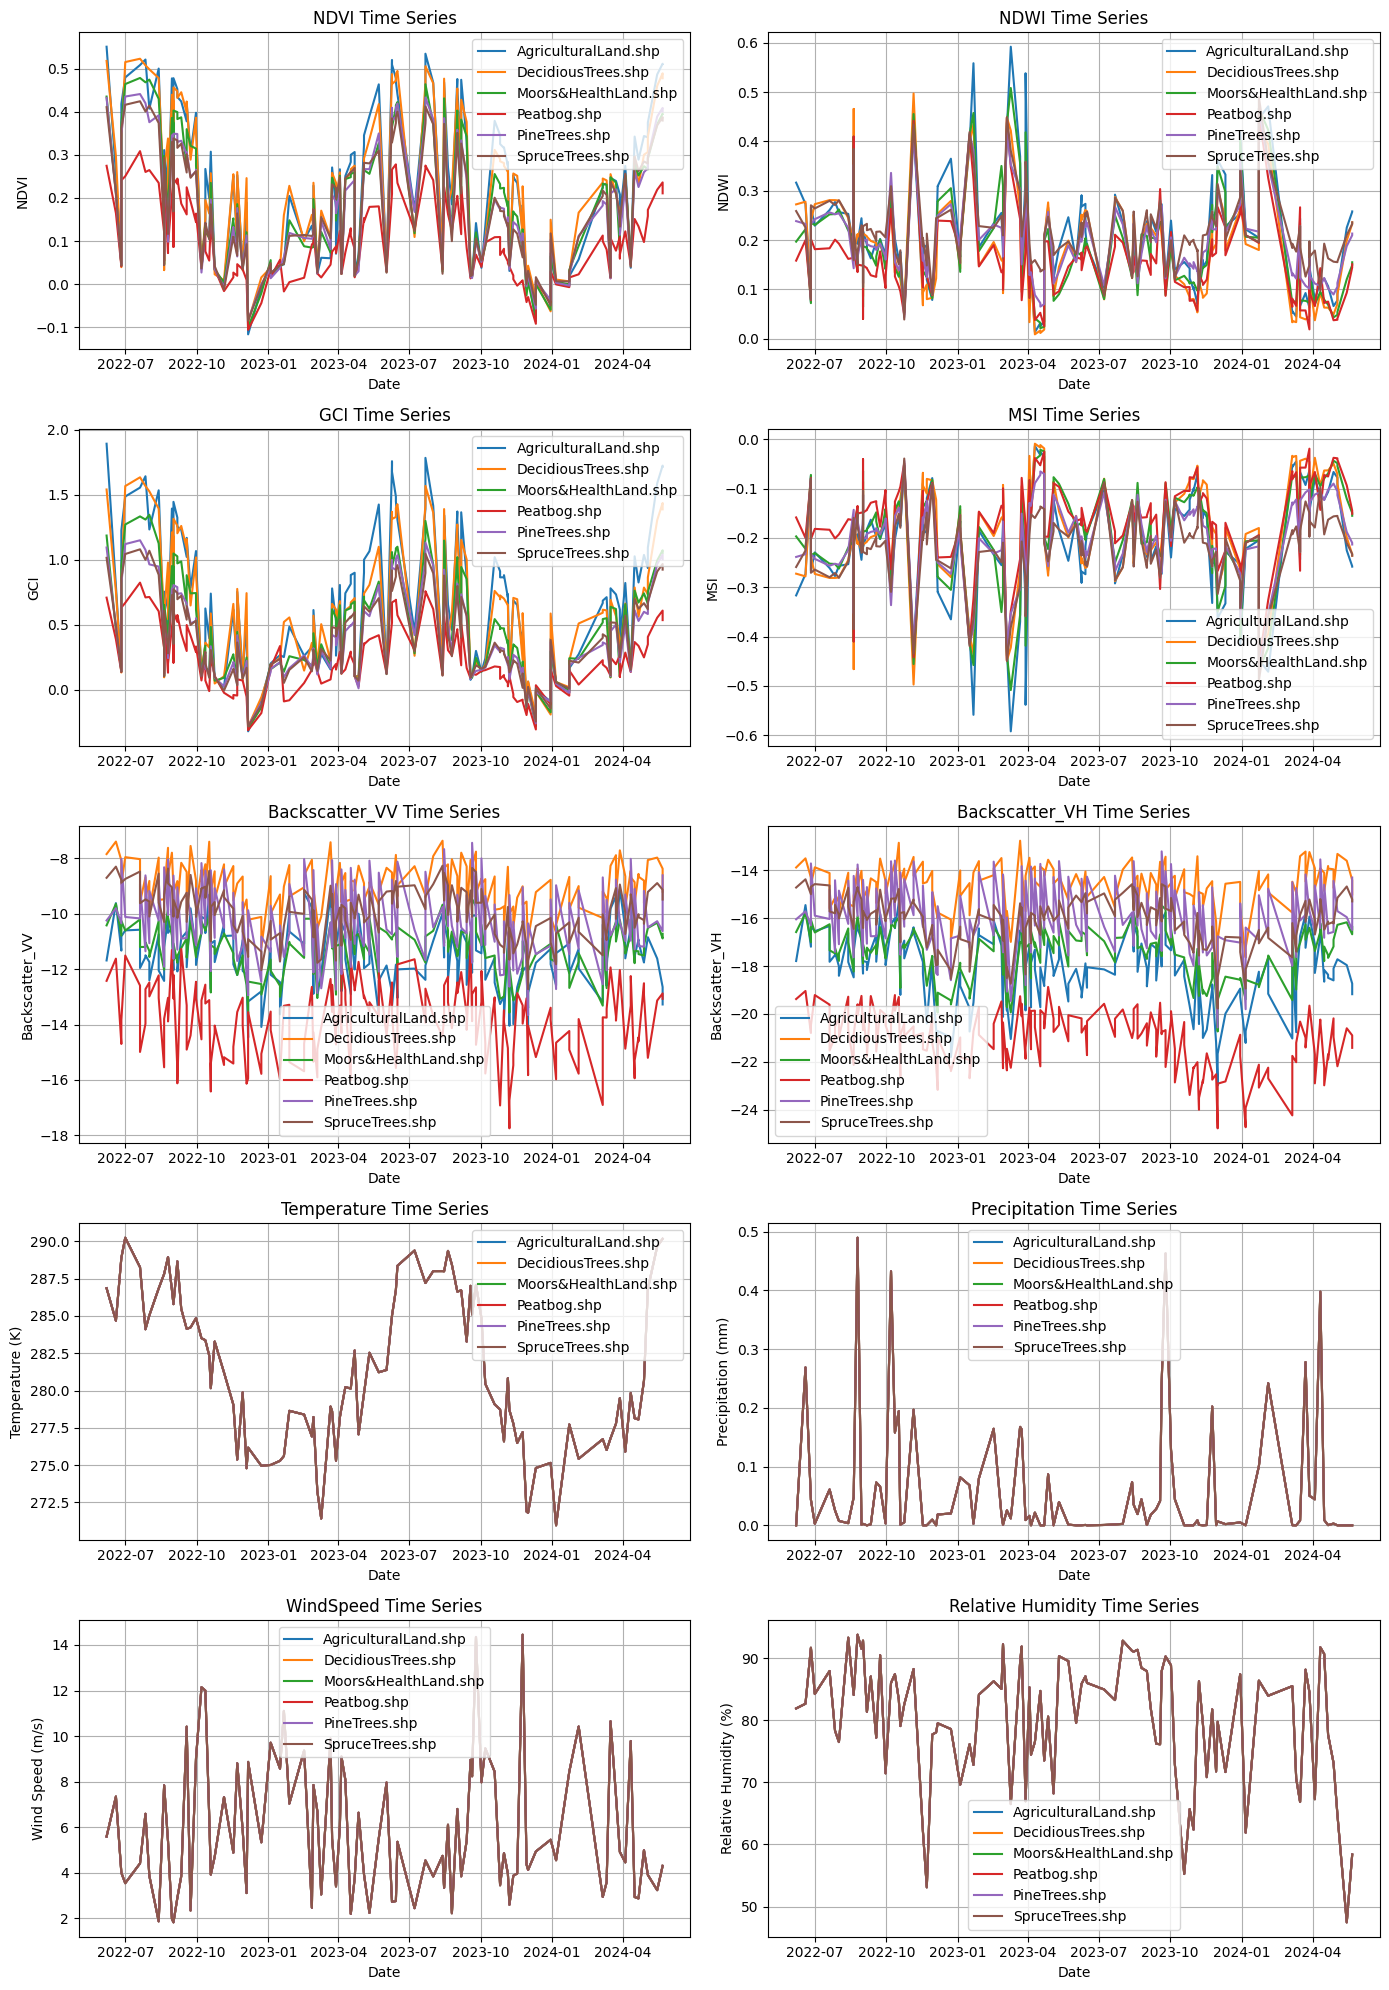

In [18]:
import matplotlib.pyplot as plt

# Plot NDVI, NDWI, GCI, and MSI
plt.figure(figsize=(14, 20))

# NDVI Time Series
plt.subplot(5, 2, 1)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['NDVI'], label=veg_type)
plt.title('NDVI Time Series')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend(loc='best')
plt.grid(True)

# NDWI Time Series
plt.subplot(5, 2, 2)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['NDWI'], label=veg_type)
plt.title('NDWI Time Series')
plt.xlabel('Date')
plt.ylabel('NDWI')
plt.legend(loc='best')
plt.grid(True)

# GCI Time Series
plt.subplot(5, 2, 3)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['GCI'], label=veg_type)
plt.title('GCI Time Series')
plt.xlabel('Date')
plt.ylabel('GCI')
plt.legend(loc='best')
plt.grid(True)

# MSI Time Series
plt.subplot(5, 2, 4)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['MSI'], label=veg_type)
plt.title('MSI Time Series')
plt.xlabel('Date')
plt.ylabel('MSI')
plt.legend(loc='best')
plt.grid(True)

# Backscatter_VV Time Series
plt.subplot(5, 2, 5)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['Backscatter_VV'], label=veg_type)
plt.title('Backscatter_VV Time Series')
plt.xlabel('Date')
plt.ylabel('Backscatter_VV')
plt.legend(loc='best')
plt.grid(True)

# Backscatter_VH Time Series
plt.subplot(5, 2, 6)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['Backscatter_VH'], label=veg_type)
plt.title('Backscatter_VH Time Series')
plt.xlabel('Date')
plt.ylabel('Backscatter_VH')
plt.legend(loc='best')
plt.grid(True)

# Temperature Time Series
plt.subplot(5, 2, 7)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['Temperature'], label=veg_type)
plt.title('Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.grid(True)

# Precipitation Time Series
plt.subplot(5, 2, 8)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['Precipitation'], label=veg_type)
plt.title('Precipitation Time Series')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend(loc='best')
plt.grid(True)

# WindSpeed Time Series
plt.subplot(5, 2, 9)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['WindSpeed'], label=veg_type)
plt.title('WindSpeed Time Series')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend(loc='best')
plt.grid(True)

# Relative Humidity Time Series
plt.subplot(5, 2, 10)
for veg_type in merged_df['Shapefile_S2'].unique():
    veg_type_data = merged_df[merged_df['Shapefile_S2'] == veg_type]
    plt.plot(veg_type_data['Date'], veg_type_data['RelativeHumidity'], label=veg_type)
plt.title('Relative Humidity Time Series')
plt.xlabel('Date')
plt.ylabel('Relative Humidity (%)')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()


## LSTM

Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0766 - val_loss: 0.0356
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0358 - val_loss: 0.0311
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 0.0289
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0279 - val_loss: 0.0280
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0272 - val_loss: 0.0274
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.0266
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0299
Epoch 8/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0294
Epoch 9/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0280
Epoch 10/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0236 - val_loss: 0.0310
Epoch 11/50
35/35 [

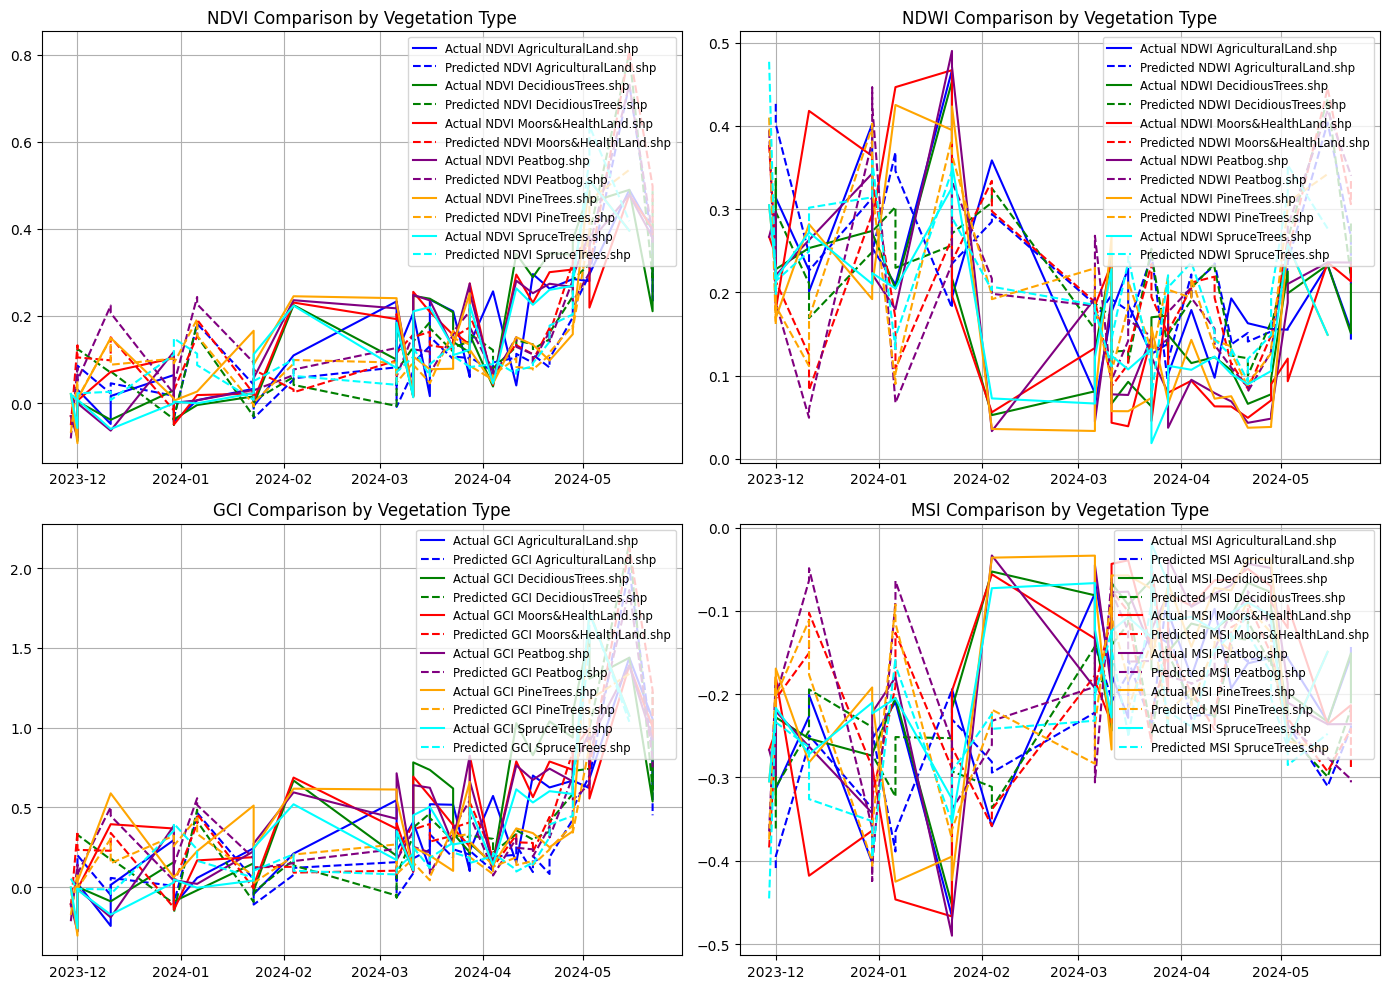

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assume merged_df is already available from previous steps

# One-hot encode the vegetation types
encoder = OneHotEncoder(sparse_output=False)
vegetation_encoded = encoder.fit_transform(merged_df[['Shapefile_S2']])

# Add encoded vegetation types to the features
encoded_columns = [f"VegType_{i}" for i in range(vegetation_encoded.shape[1])]
merged_df[encoded_columns] = vegetation_encoded

# Feature columns (including encoded vegetation types) and target columns
feature_columns = ['Temperature', 'Precipitation', 'RelativeHumidity', 'Backscatter_VV', 'Backscatter_VH'] + encoded_columns
target_columns = ['NDVI', 'NDWI', 'GCI', 'MSI']

# Scale the features and targets
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(merged_df[feature_columns])
scaled_targets = target_scaler.fit_transform(merged_df[target_columns])

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(merged_df) * 0.8)
train_features, test_features = scaled_features[:train_size], scaled_features[train_size:]
train_targets, test_targets = scaled_targets[:train_size], scaled_targets[train_size:]

# Prepare training and testing dates
train_dates = merged_df['Date'][:train_size].reset_index(drop=True)
test_dates = merged_df['Date'][train_size:].reset_index(drop=True)

# Create time series generators for LSTM
sequence_length = 10

def create_timeseries_generator(features, targets, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        y.append(targets[i + sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_timeseries_generator(train_features, train_targets, sequence_length)
X_test, y_test = create_timeseries_generator(test_features, test_targets, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))  # Output layer for NDVI, NDWI, GCI, and MSI
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the target predictions
predicted_values = target_scaler.inverse_transform(predictions)
actual_values = target_scaler.inverse_transform(y_test)

# Extract NDVI, NDWI, GCI, and MSI from predictions and actual values
predicted_ndvi, predicted_ndwi, predicted_gci, predicted_msi = predicted_values.T
actual_ndvi, actual_ndwi, actual_gci, actual_msi = actual_values.T

# Calculate metrics for evaluation
metrics = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE'],
    'NDVI': [
        mean_absolute_error(actual_ndvi, predicted_ndvi),
        mean_squared_error(actual_ndvi, predicted_ndvi, squared=False),
        mean_absolute_percentage_error(actual_ndvi, predicted_ndvi)
    ],
    'NDWI': [
        mean_absolute_error(actual_ndwi, predicted_ndwi),
        mean_squared_error(actual_ndwi, predicted_ndwi, squared=False),
        mean_absolute_percentage_error(actual_ndwi, predicted_ndwi)
    ],
    'GCI': [
        mean_absolute_error(actual_gci, predicted_gci),
        mean_squared_error(actual_gci, predicted_gci, squared=False),
        mean_absolute_percentage_error(actual_gci, predicted_gci)
    ],
    'MSI': [
        mean_absolute_error(actual_msi, predicted_msi),
        mean_squared_error(actual_msi, predicted_msi, squared=False),
        mean_absolute_percentage_error(actual_msi, predicted_msi)
    ]
})

print(metrics)

# Prepare test dates for plotting
test_dates = test_dates.reset_index(drop=True)[:len(actual_ndvi)]

# Define a consistent color map for vegetation types
colors = {
    'AgriculturalLand.shp': 'blue',
    'DecidiousTrees.shp': 'green',
    'Moors&HealthLand.shp': 'red',
    'Peatbog.shp': 'purple',
    'PineTrees.shp': 'orange',
    'SpruceTrees.shp': 'cyan'
}

# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# NDVI comparison
ax = axs[0, 0]
for veg_type in encoder.categories_[0]:
    veg_type_mask = (merged_df['Shapefile_S2'].iloc[train_size:train_size + len(test_dates)].values == veg_type)
    veg_type_mask = veg_type_mask[:len(actual_ndvi)]  # Ensure mask length matches actual/predicted length

    if np.any(veg_type_mask):  # Plot only if there is data for this vegetation type
        color = colors.get(veg_type, 'black')  # Default color if not found
        ax.plot(test_dates[veg_type_mask], actual_ndvi[veg_type_mask], label=f'Actual NDVI {veg_type}', linestyle='-', color=color)
        ax.plot(test_dates[veg_type_mask], predicted_ndvi[veg_type_mask], label=f'Predicted NDVI {veg_type}', linestyle='--', color=color)

ax.set_title('NDVI Comparison by Vegetation Type')
ax.legend(loc='upper right', fontsize='small')
ax.grid(True)

# NDWI comparison
ax = axs[0, 1]
for veg_type in encoder.categories_[0]:
    veg_type_mask = (merged_df['Shapefile_S2'].iloc[train_size:train_size + len(test_dates)].values == veg_type)
    veg_type_mask = veg_type_mask[:len(actual_ndwi)]

    if np.any(veg_type_mask):
        color = colors.get(veg_type, 'black')
        ax.plot(test_dates[veg_type_mask], actual_ndwi[veg_type_mask], label=f'Actual NDWI {veg_type}', linestyle='-', color=color)
        ax.plot(test_dates[veg_type_mask], predicted_ndwi[veg_type_mask], label=f'Predicted NDWI {veg_type}', linestyle='--', color=color)

ax.set_title('NDWI Comparison by Vegetation Type')
ax.legend(loc='upper right', fontsize='small')
ax.grid(True)

# GCI comparison
ax = axs[1, 0]
for veg_type in encoder.categories_[0]:
    veg_type_mask = (merged_df['Shapefile_S2'].iloc[train_size:train_size + len(test_dates)].values == veg_type)
    veg_type_mask = veg_type_mask[:len(actual_gci)]

    if np.any(veg_type_mask):
        color = colors.get(veg_type, 'black')
        ax.plot(test_dates[veg_type_mask], actual_gci[veg_type_mask], label=f'Actual GCI {veg_type}', linestyle='-', color=color)
        ax.plot(test_dates[veg_type_mask], predicted_gci[veg_type_mask], label=f'Predicted GCI {veg_type}', linestyle='--', color=color)

ax.set_title('GCI Comparison by Vegetation Type')
ax.legend(loc='upper right', fontsize='small')
ax.grid(True)

# MSI comparison
ax = axs[1, 1]
for veg_type in encoder.categories_[0]:
    veg_type_mask = (merged_df['Shapefile_S2'].iloc[train_size:train_size + len(test_dates)].values == veg_type)
    veg_type_mask = veg_type_mask[:len(actual_msi)]

    if np.any(veg_type_mask):
        color = colors.get(veg_type, 'black')
        ax.plot(test_dates[veg_type_mask], actual_msi[veg_type_mask], label=f'Actual MSI {veg_type}', linestyle='-', color=color)
        ax.plot(test_dates[veg_type_mask], predicted_msi[veg_type_mask], label=f'Predicted MSI {veg_type}', linestyle='--', color=color)

ax.set_title('MSI Comparison by Vegetation Type')
ax.legend(loc='upper right', fontsize='small')
ax.grid(True)

# Adjust layout to ensure plots don't overlap
plt.tight_layout()
plt.show()



They complement each other:
*MAE* gives an average error without penalizing outliers.
*RMSE* highlights cases where large errors occur.
*MAPE* offers a relative error measure, useful for datasets with varying scales.
Together, they provide a comprehensive view of model accuracy, addressing both absolute and relative performance across different indices like NDVI, NDWI, GCI, and MSI.

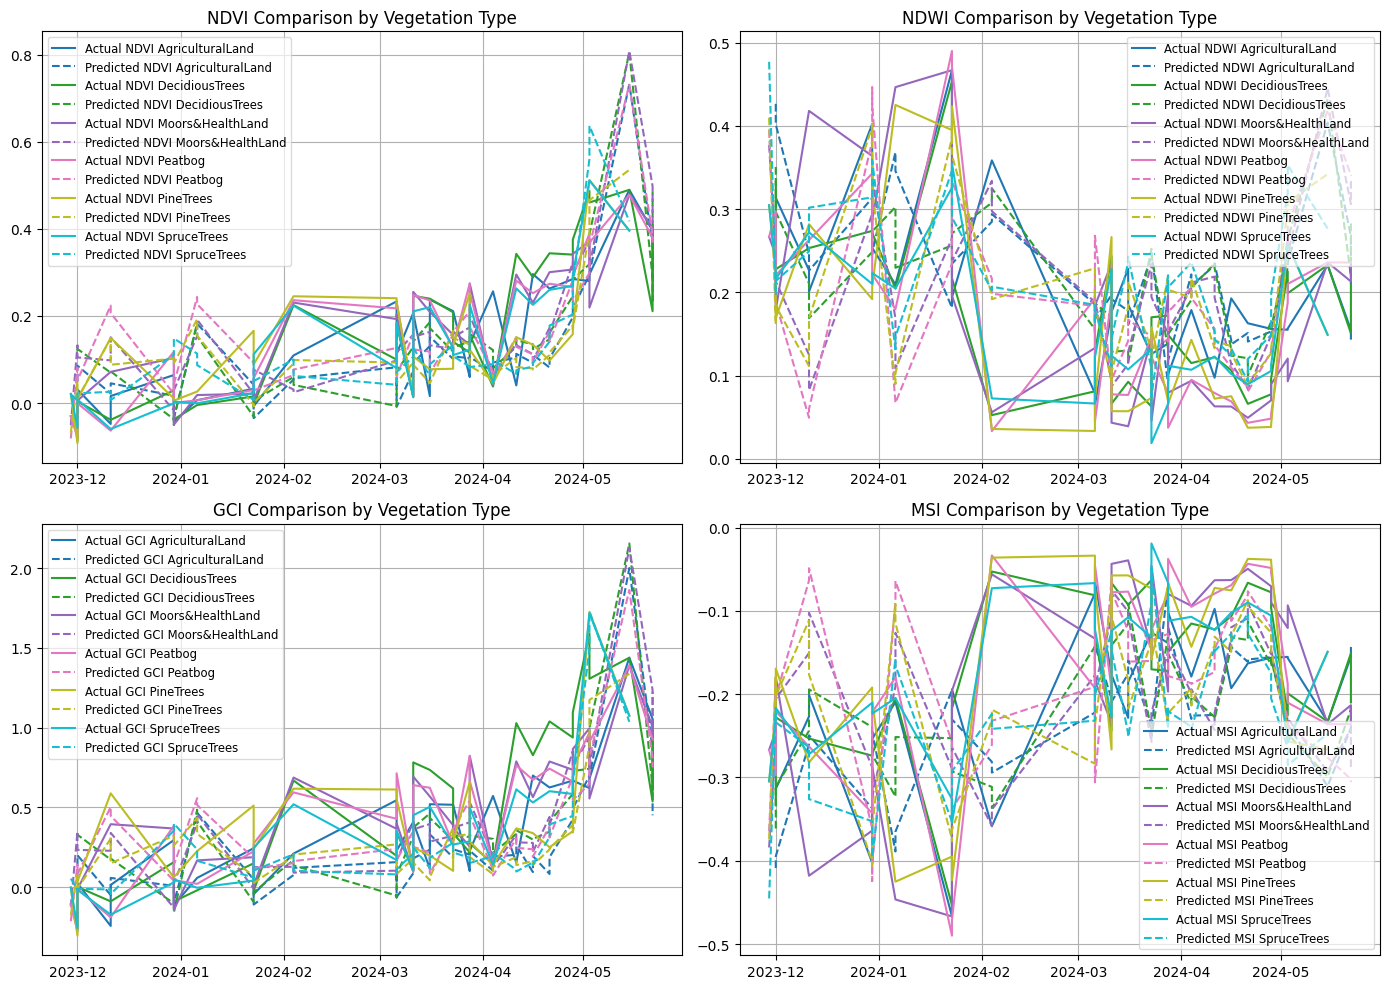

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define consistent color map for vegetation types using matplotlib's tab10 color map
colors = plt.cm.tab10(np.linspace(0, 1, len(encoder.categories_[0])))

# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# NDVI comparison (Top Left)
ax = axs[0, 0]
for i, veg_type in enumerate(encoder.categories_[0]):
    veg_type_mask = (merged_df['Shapefile_S2'].iloc[train_size:train_size + len(test_dates)].values == veg_type)
    veg_type_mask = veg_type_mask[:len(actual_ndvi)]  # Ensure mask length matches actual/predicted length

    if np.any(veg_type_mask):  # Plot only if there is data for this vegetation type
        color = colors[i]  # Color for this vegetation type
        veg_type_clean = veg_type.replace(".shp", "")  # Remove ".shp"
        ax.plot(test_dates[veg_type_mask], actual_ndvi[veg_type_mask], label=f'Actual NDVI {veg_type_clean}', linestyle='-', color=color)
        ax.plot(test_dates[veg_type_mask], predicted_ndvi[veg_type_mask], label=f'Predicted NDVI {veg_type_clean}', linestyle='--', color=color)

ax.set_title('NDVI Comparison by Vegetation Type')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize='small', framealpha=0.7)  # Move legend a bit more inside
ax.grid(True)

# NDWI comparison (Top Right)
ax = axs[0, 1]
for i, veg_type in enumerate(encoder.categories_[0]):
    veg_type_mask = (merged_df['Shapefile_S2'].iloc[train_size:train_size + len(test_dates)].values == veg_type)
    veg_type_mask = veg_type_mask[:len(actual_ndwi)]

    if np.any(veg_type_mask):
        color = colors[i]
        veg_type_clean = veg_type.replace(".shp", "")  # Remove ".shp"
        ax.plot(test_dates[veg_type_mask], actual_ndwi[veg_type_mask], label=f'Actual NDWI {veg_type_clean}', linestyle='-', color=color)
        ax.plot(test_dates[veg_type_mask], predicted_ndwi[veg_type_mask], label=f'Predicted NDWI {veg_type_clean}', linestyle='--', color=color)

ax.set_title('NDWI Comparison by Vegetation Type')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='small', framealpha=0.7)
ax.grid(True)

# GCI comparison (Bottom Left)
ax = axs[1, 0]
for i, veg_type in enumerate(encoder.categories_[0]):
    veg_type_mask = (merged_df['Shapefile_S2'].iloc[train_size:train_size + len(test_dates)].values == veg_type)
    veg_type_mask = veg_type_mask[:len(actual_gci)]

    if np.any(veg_type_mask):
        color = colors[i]
        veg_type_clean = veg_type.replace(".shp", "")  # Remove ".shp"
        ax.plot(test_dates[veg_type_mask], actual_gci[veg_type_mask], label=f'Actual GCI {veg_type_clean}', linestyle='-', color=color)
        ax.plot(test_dates[veg_type_mask], predicted_gci[veg_type_mask], label=f'Predicted GCI {veg_type_clean}', linestyle='--', color=color)

ax.set_title('GCI Comparison by Vegetation Type')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize='small', framealpha=0.7)
ax.grid(True)

# MSI comparison (Bottom Right)
ax = axs[1, 1]
for i, veg_type in enumerate(encoder.categories_[0]):
    veg_type_mask = (merged_df['Shapefile_S2'].iloc[train_size:train_size + len(test_dates)].values == veg_type)
    veg_type_mask = veg_type_mask[:len(actual_msi)]

    if np.any(veg_type_mask):
        color = colors[i]
        veg_type_clean = veg_type.replace(".shp", "")  # Remove ".shp"
        ax.plot(test_dates[veg_type_mask], actual_msi[veg_type_mask], label=f'Actual MSI {veg_type_clean}', linestyle='-', color=color)
        ax.plot(test_dates[veg_type_mask], predicted_msi[veg_type_mask], label=f'Predicted MSI {veg_type_clean}', linestyle='--', color=color)

ax.set_title('MSI Comparison by Vegetation Type')
ax.legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize='small', framealpha=0.7)
ax.grid(True)

# Adjust layout to ensure plots don't overlap
plt.tight_layout()

# Save the figure as a PDF
plt.savefig("comparison_by_vegetation.pdf", format='pdf')

plt.show()


## Monte Carlo Dropout ( Uncertainty estimation) 
The plot demonstrates the model's predictions for NDVI values along with uncertainty estimates using Monte Carlo Dropout. The **blue line** represents the actual NDVI values, while the **orange line** shows the predicted mean NDVI based on 100 stochastic forward passes. The **shaded orange region** indicates the 95% confidence interval, representing the model's uncertainty. Narrower regions suggest higher confidence, while wider intervals highlight areas of greater uncertainty, which may arise from complex inputs, out-of-distribution data, or limited training samples. Overall, the actual NDVI values mostly lie within the confidence intervals, indicating that the model captures trends well and provides reliable uncertainty estimates. This approach helps quantify the reliability of predictions, making it valuable for real-world decision-making.

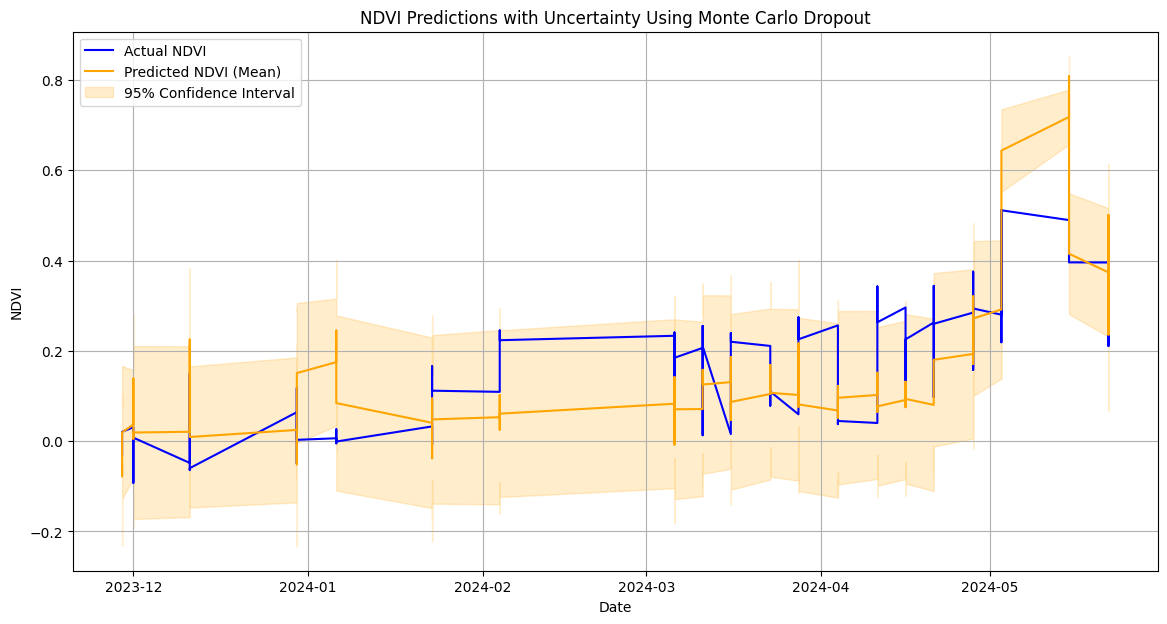

In [21]:
# Define a Monte Carlo prediction function for modern TensorFlow
def monte_carlo_predictions_v2(model, X_test, n_simulations=100):
    preds = np.array([model(X_test, training=True).numpy() for _ in range(n_simulations)])
    return preds

# Perform Monte Carlo simulations
n_simulations = 100  # Number of stochastic passes
mc_predictions = monte_carlo_predictions_v2(model, X_test, n_simulations)

# Compute mean and uncertainty (standard deviation)
mc_mean = mc_predictions.mean(axis=0)  # Mean prediction
mc_std = mc_predictions.std(axis=0)    # Standard deviation (uncertainty)

# Inverse transform the predictions
predicted_values_mc_mean = target_scaler.inverse_transform(mc_mean)
predicted_values_mc_std = target_scaler.inverse_transform(mc_std)

# Extract NDVI mean and standard deviation
predicted_ndvi_mean = predicted_values_mc_mean[:, 0]
predicted_ndvi_std = predicted_values_mc_std[:, 0]

# Plotting NDVI with uncertainty bounds
plt.figure(figsize=(14, 7))
plt.plot(test_dates, actual_ndvi, label='Actual NDVI', color='blue')
plt.plot(test_dates, predicted_ndvi_mean, label='Predicted NDVI (Mean)', color='orange')
plt.fill_between(test_dates,
                 predicted_ndvi_mean - 1.96 * predicted_ndvi_std,
                 predicted_ndvi_mean + 1.96 * predicted_ndvi_std,
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title("NDVI Predictions with Uncertainty Using Monte Carlo Dropout")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True)
plt.show()


## Explainable AI (XAI)
The SHAP summary plot visualizes the distribution of SHAP values for each feature, showing how they impact the model's output.

In [22]:
import shap

# Define a helper function for SHAP to predict
def model_predict_3d(input_data):
    input_data_3d = input_data.reshape(input_data.shape[0], sequence_length, len(feature_columns))
    return model.predict(input_data_3d)

# Reshape X_test for SHAP (flattened features)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (num_samples, sequence_length * num_features)

# Create feature names for SHAP analysis (include timesteps in the names)
sequence_length = 10
feature_names = [
    f"{feature}_t-{t}" for t in range(sequence_length - 1, -1, -1) for feature in feature_columns
]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict_3d, X_test_flat)

# Calculate SHAP values (e.g., for the first 100 samples)
shap_values = explainer.shap_values(X_test_flat[:100])

# Save the SHAP values (optional)
np.save('shap_values.npy', shap_values)

# Print SHAP values shape
print(f"SHAP values shape: {np.array(shap_values).shape}")  # (num_targets, num_samples, num_features)


9/9 [==============================] - 0s 3ms/step


Using 270 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

19137/19137 [==============================] - 27s 1ms/step


19137/19137 [==============================] - 25s 1ms/step
SHAP values shape: (100, 110, 4)


## Summary
The SHAP visualizations reveal key insights into the relationships between precipitation, temperature, and vegetation indices. The SHAP summary plot shows that precipitation has the greatest impact on vegetation health, with higher precipitation increasing NDVI and NDWI values. Temperature, however, has a negative effect, with higher temperatures leading to reduced vegetation health. Vegetation types also influence the predictions but to a lesser degree than climatic variables.

The bar plot of mean SHAP values confirms that precipitation is the most influential factor, while temperature negatively affects vegetation indices. These results suggest that water availability (precipitation) supports vegetation moisture, while higher temperatures stress vegetation, aligning with known ecological dynamics.

In [80]:
shap_values_ndwi = shap_values[:, :, 1]  # Extract SHAP values for NDVI (the first target)
print("Shape of shap_values_ndwi:", shap_values_ndvi.shape)

Shape of shap_values_ndwi: (100, 110)


In [77]:
grouped_features_dict = {
    "Precipitation": [index for index, name in enumerate(feature_names) if "Precipitation" in name],
    "Temperature": [index for index, name in enumerate(feature_names) if "Temperature" in name],
    "Vegetation Type": [index for index, name in enumerate(feature_names) if "VegType" in name],
    "Backscatter": [index for index, name in enumerate(feature_names) if "Backscatter" in name],
    "RelativeHumidity": [index for index, name in enumerate(feature_names) if "RelativeHumidity" in name],
   

}


In [78]:
grouped_shap_values = []
grouped_feature_values = []
grouped_feature_names = []

for group_name, feature_indices in grouped_features_dict.items():
    # Aggregate SHAP values for the group
    grouped_shap_values.append(shap_values_ndwi[:, feature_indices].sum(axis=1))
    # Aggregate feature values for the group
    grouped_feature_values.append(aligned_features[:, feature_indices].mean(axis=1))
    # Store group name
    grouped_feature_names.append(group_name)

# Convert lists to NumPy arrays and transpose
grouped_shap_values = np.array(grouped_shap_values).T  # Shape: (samples, groups)
grouped_feature_values = np.array(grouped_feature_values).T  # Shape: (samples, groups)

# Debugging: Check shapes after alignment
print("Grouped SHAP Values Shape (after alignment):", grouped_shap_values.shape)
print("Grouped Feature Values Shape (after alignment):", grouped_feature_values.shape)


Grouped SHAP Values Shape (after alignment): (100, 5)
Grouped Feature Values Shape (after alignment): (100, 5)


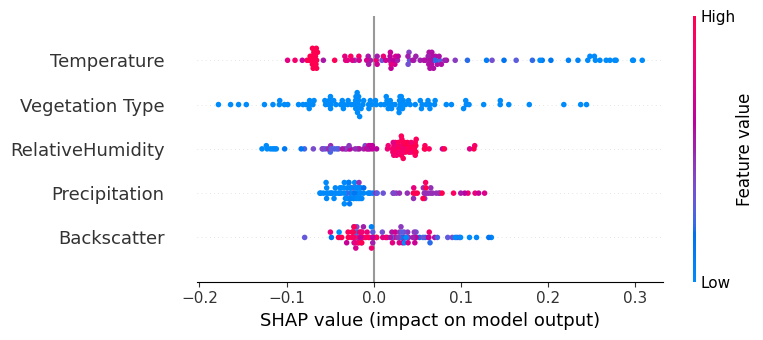

In [79]:
shap.summary_plot(
    grouped_shap_values, 
    grouped_feature_values, 
    feature_names=grouped_feature_names
)
